In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
# Load the 'furniture' sales data
furniture = pd.read_csv("Super_Store_data.csv", encoding='cp1252')

In [3]:
# Convert 'Order Date' to datetime and set it as index
furniture["Order Date"] = pd.to_datetime(furniture["Order Date"])
furniture.set_index("Order Date", inplace=True)

In [4]:
# Group by 'Order Date' and sum 'Sales'
furniture = furniture.groupby("Order Date")['Sales'].sum().reset_index()

In [5]:
# Resample the data to get the monthly mean
y = furniture.set_index("Order Date")["Sales"].resample('MS').mean()  # MS means Month Start

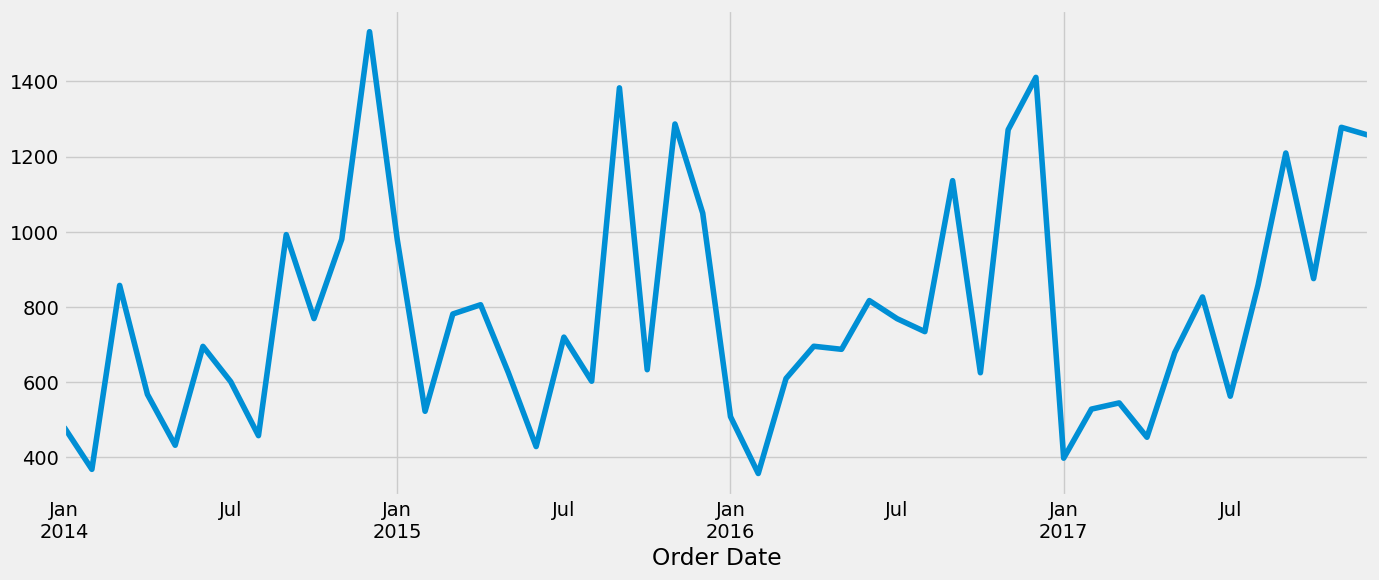

In [6]:
# Plot the time series data
y.plot(figsize=(15, 6))
plt.show()


In [7]:
# Check stationarity using Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

In [8]:
result = adfuller(y)
print("ADF Statistic:", result[0])
print('P-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -5.1910701873392755
P-value: 9.16875665566545e-06
Critical Values:
	1%: -3.6209175221605827
	5%: -2.9435394610388332
	10%: -2.6104002410518627


In [9]:
# Decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose

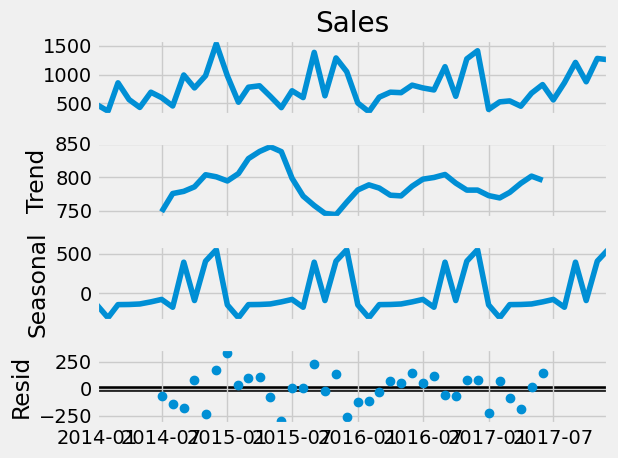

In [10]:
decomposition = seasonal_decompose(y)
decomposition.plot()
plt.show()

In [11]:
# SARIMA model parameter selection
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [12]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[1]}')
print(f'SARIMAX: {pdq[1]} x {seasonal_pdq[2]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[3]}')
print(f'SARIMAX: {pdq[2]} x {seasonal_pdq[4]}')

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [13]:
# Parameter selection using AIC
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None

In [14]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                tmp_model = results
            print(f'ARIMA{param}x{param_seasonal}12 - AIC:{results.aic}')
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1468.9767061425216
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.71701309212006
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.27028997935867
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418338
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:971.4586816721037
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.24882803027316
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758135
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2692.1926701458115
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809145
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673286
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.57960304472334
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2527.7588971725136
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946867
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.872557652452
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.8947668414504
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1348.8490608874254
ARI

In [15]:
print(f'Best model: ARIMA{best_pdq}x{best_seasonal_pdq}12 - AIC:{best_aic}')

Best model: ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.5806233406845


In [16]:
# Forecasting
pred = tmp_model.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

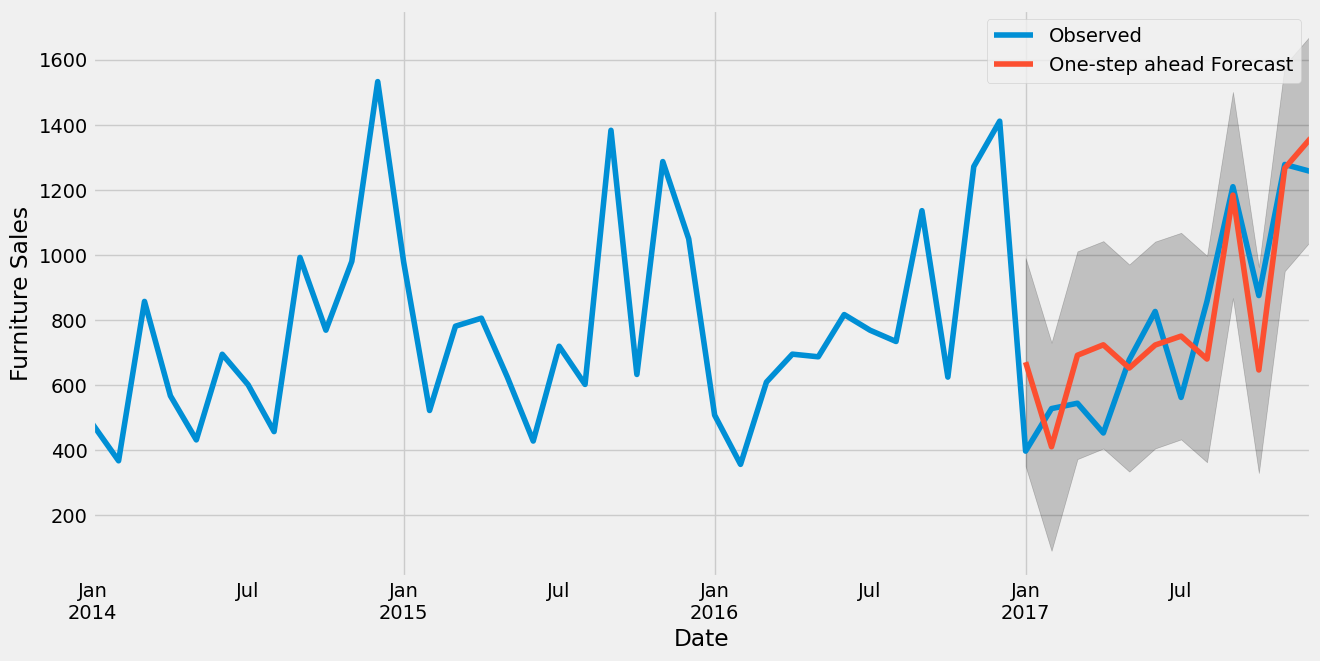

In [17]:
ax = y['2014':].plot(label='Observed', figsize=(14, 7))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=1)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [18]:
# Calculate RMSE
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is', round(np.sqrt(mse), 2))

The Root Mean Squared Error of our forecasts is 164.59


In [19]:
# Forecasting for the next 13 months
pred_uc = tmp_model.get_forecast(steps=13)
pred_ci = pred_uc.conf_int()

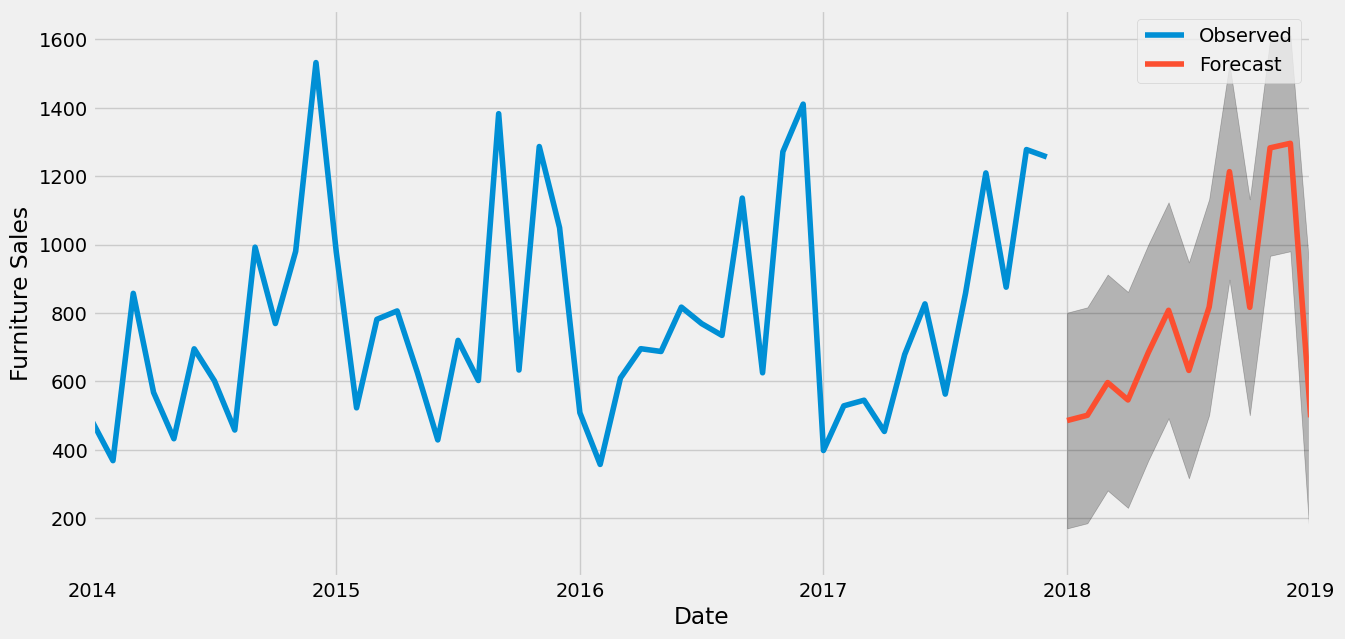

In [20]:
ax = y.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [21]:
print(pred_ci)

            lower Sales  upper Sales
2018-01-01   169.636327   800.791948
2018-02-01   184.856996   816.402176
2018-03-01   280.604895   912.149347
2018-04-01   229.754090   861.298541
2018-05-01   368.004669   999.549120
2018-06-01   491.916182  1123.460634
2018-07-01   316.102455   947.646906
2018-08-01   501.563993  1133.108444
2018-09-01   897.528996  1529.073447
2018-10-01   500.577940  1132.122391
2018-11-01   967.036477  1598.580928
2018-12-01   980.347355  1611.891832
2019-01-01   104.211670   885.323095


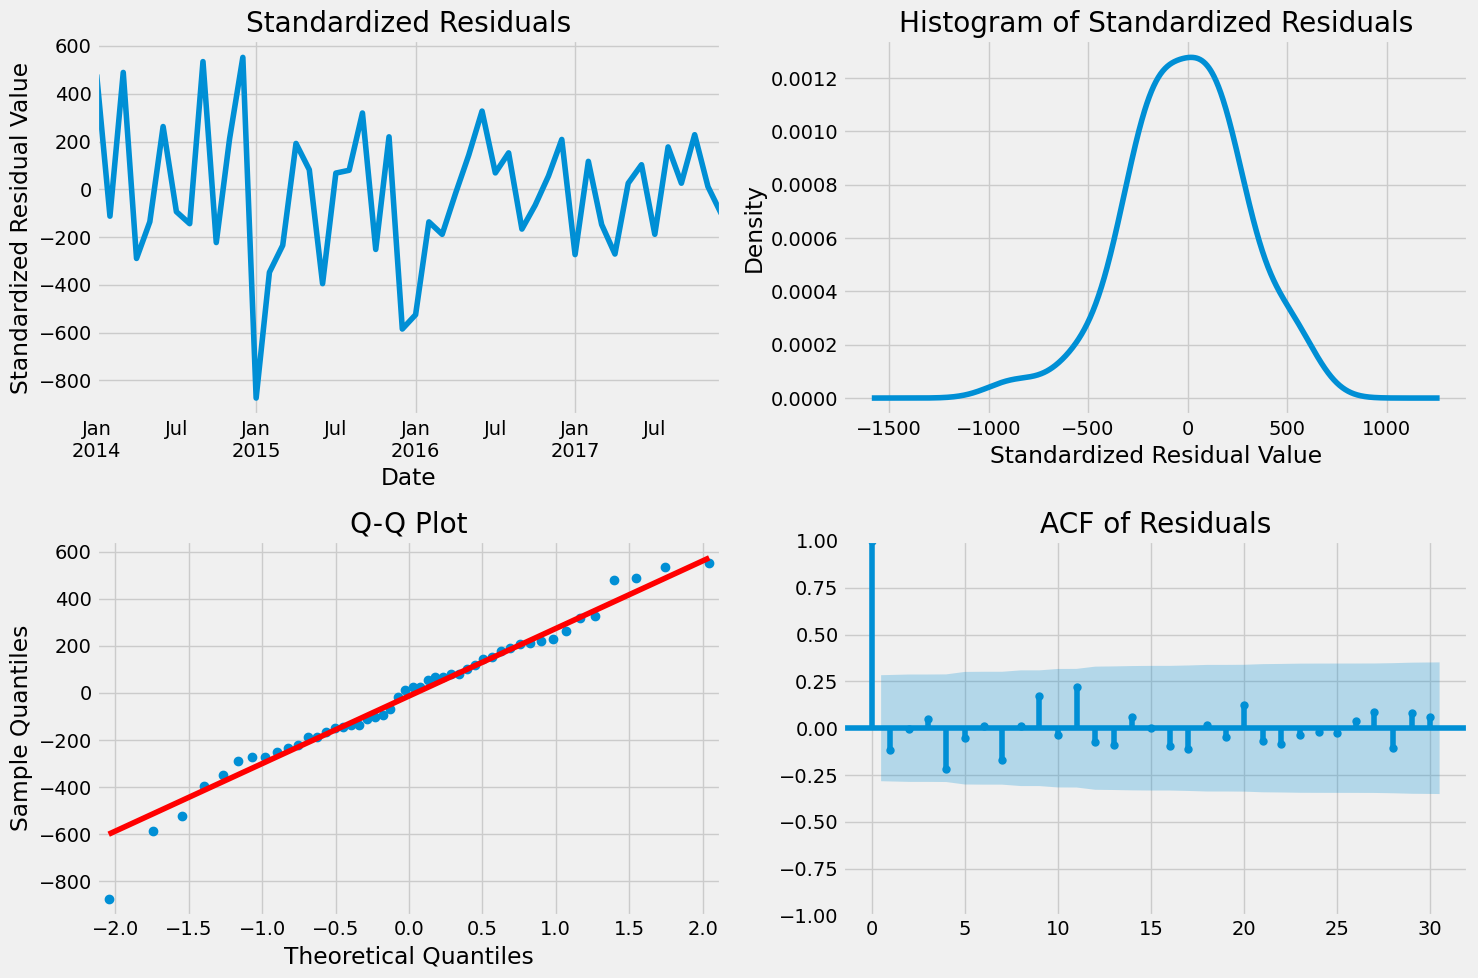

In [22]:
# Diagnostic plots for the SARIMA model
def plot_diagnostics(residuals, lags=30):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    # Standardized residual plot
    residuals.plot(ax=ax[0, 0])
    ax[0, 0].set_title('Standardized Residuals')
    ax[0, 0].set_xlabel('Date')
    ax[0, 0].set_ylabel('Standardized Residual Value')

    # Histogram plot
    residuals.plot(kind='kde', ax=ax[0, 1])
    ax[0, 1].set_title('Histogram of Standardized Residuals')
    ax[0, 1].set_xlabel('Standardized Residual Value')

    # Q-Q plot
    from statsmodels.graphics.gofplots import qqplot
    qqplot(residuals, line='s', ax=ax[1, 0])
    ax[1, 0].set_title('Q-Q Plot')

    # ACF plot
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(residuals, lags=lags, ax=ax[1, 1])
    ax[1, 1].set_title('ACF of Residuals')

    plt.tight_layout()
    plt.show()

# Get the residuals of the best model
residuals = tmp_model.resid

# Plot diagnostics
plot_diagnostics(residuals)
